## Recurrent Neural Network

In [1]:
from tensorflow import keras

### [Elman Network](https://en.wikipedia.org/wiki/Recurrent_neural_network#Elman_networks_and_Jordan_networks)


In [2]:
# Preparing data
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500) # Use only 500 words(tokens)

print(train_input.shape, test_input.shape)

# Print length(tokens) of review samples
print(len(train_input[0]))
print(len(train_input[1]))

# Print target data
print(train_target[:10]) # first 20 target labels

(25000,) (25000,)
218
189
[1 0 0 1 0 0 1 0 1 0]


239.00925 178.0


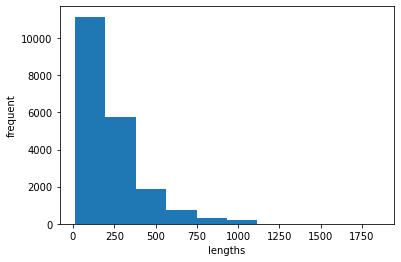

(20000, 100) (5000, 100)
100
100
[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [3]:
# Preprocessing data
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

# Print average and median of review lengths
import numpy as np

lengths = np.array([len(x) for x in train_input])
print(np.mean(lengths), np.median(lengths))

# Plot histogram of review lengths
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel('lengths')
plt.ylabel('frequent')
plt.show()

# Truncate / Pad sequences to length 100
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100) # Default: padding='pre', truncating='pre'
val_seq = pad_sequences(val_input, maxlen=100)

print(train_seq.shape, val_seq.shape)

# Print length(tokens) of review samples
print(len(train_seq[0]))
print(len(train_seq[1]))

print(train_seq[5]) # example with pre padding

In [4]:
# Build rnn model
model = keras.Sequential()
# recurrent layer: 8 neurons(=output dimension), 500 vocabulary(one-hot-encoding)
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500))) # Default: activation='tanh', return_sequences=False (set True except last rnn layer)
# fully connected layer(dense layer)
model.add(keras.layers.Dense(1, activation='sigmoid')) # binary classification

# One-hot-encoding on input sequences (over vocabulary of 500 words)
train_oh = keras.utils.to_categorical(train_seq)
val_oh = keras.utils.to_categorical(val_seq)

print(train_oh.shape, val_oh.shape)

# sum of sequence should be 1
print(np.sum(train_oh[0][0]))

(20000, 100, 500) (5000, 100, 500)
1.0


In [5]:
model.summary()
print('Model Paramters for recurrent layer: (num of features + num of neurons) * num of neurons + biases')
print('(500 + 8) * 8 + 8  = 4072')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________
Model Paramters for recurrent layer: (num of features + num of neurons) * num of neurons + biases
(500 + 8) * 8 + 8  = 4072


In [6]:
# Train the model
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4) # RMSpro with learning rate 0.0001
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64, # Default: batch_size=32 (Mini-Batch)
                    validation_data=(val_oh, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 53s 156ms/step - loss: 0.6939 - accuracy: 0.5227 - val_loss: 0.6851 - val_accuracy: 0.5566
Epoch 2/100
313/313 [==============================] - 52s 166ms/step - loss: 0.6689 - accuracy: 0.6011 - val_loss: 0.6667 - val_accuracy: 0.6078
Epoch 3/100
313/313 [==============================] - 60s 192ms/step - loss: 0.6482 - accuracy: 0.6434 - val_loss: 0.6462 - val_accuracy: 0.6434
Epoch 4/100
313/313 [==============================] - 41s 130ms/step - loss: 0.6268 - accuracy: 0.6767 - val_loss: 0.6271 - val_accuracy: 0.6740
Epoch 5/100
313/313 [==============================] - 41s 132ms/step - loss: 0.6060 - accuracy: 0.7031 - val_loss: 0.6085 - val_accuracy: 0.6930
Epoch 6/100
313/313 [==============================] - 39s 125ms/step - loss: 0.5864 - accuracy: 0.7239 - val_loss: 0.5927 - val_accuracy: 0.7064
Epoch 7/100
313/313 [==============================] - 40s 128ms/step - loss: 0.5682 - accuracy: 0.7363 - val_loss: 0.5716 -

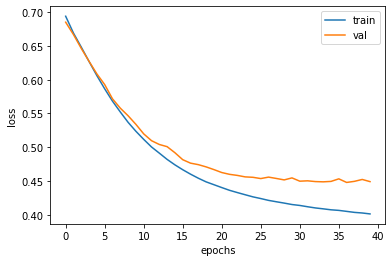

In [7]:
# Plot train loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### Word Embedding
- Word vectors with fewer dimensions
- SVD, Word2Vec, GloVe


In [24]:
# Input exploding from one-hot-encoding
print(train_seq.nbytes, train_oh.nbytes)
print(train_seq.shape, train_oh.shape)

# compare with word-embedding (untrained)
no_training_model = keras.Sequential()
# input_dim(vocabulary/tokens), output_vector(length of vector for each token), input_length)
no_training_model.add(keras.layers.Embedding(500, 16, input_length=100)) # 

# Print embedding vector
pred = no_training_model.predict(train_seq[0:1])
print(pred.shape)
print(pred)
print()

# Print embedding weights (randomly initialized; or can add pre-trained embeddings)
embedding_weights = no_training_model.layers[0].weights
print(embedding_weights)
print('num of model parameter = 500 * 16 = 8000')

8000000 4000000000
(20000, 100) (20000, 100, 500)
(1, 100, 16)
[[[ 0.01329143 -0.0390319  -0.04173241 ... -0.01522893  0.02867868
   -0.01057061]
  [ 0.03569556 -0.0168233   0.03797588 ...  0.01221947 -0.03486975
   -0.03601493]
  [ 0.04989504 -0.01281431 -0.02007943 ... -0.00062327 -0.03532375
   -0.02892484]
  ...
  [ 0.01329143 -0.0390319  -0.04173241 ... -0.01522893  0.02867868
   -0.01057061]
  [ 0.01788123 -0.01021128 -0.04709661 ... -0.03221039 -0.00661228
    0.01835288]
  [-0.03339117 -0.00718524 -0.00802974 ...  0.040504    0.02223456
    0.04726377]]]

[<tf.Variable 'embedding_14/embeddings:0' shape=(500, 16) dtype=float32, numpy=
array([[ 0.02947075, -0.02364246, -0.01452837, ...,  0.02787786,
         0.02135995,  0.04446826],
       [ 0.02863346,  0.01244665,  0.01262582, ..., -0.04875243,
         0.04013533, -0.04252584],
       [-0.00155369,  0.00483115, -0.02299144, ...,  0.01566069,
         0.01620999,  0.04176505],
       ...,
       [-0.03689463,  0.03946367,  0.0

In [23]:
# Build rnn model with Embedding
model2 = keras.Sequential()
# Embedding layer 
model2.add(keras.layers.Embedding(500, 16, input_length=100))
# recurrent layer
model2.add(keras.layers.SimpleRNN(8))
# fully connected layer(dense layer)
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 100, 16)           8000      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Train the model
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 60s 188ms/step - loss: 0.6879 - accuracy: 0.5440 - val_loss: 0.6661 - val_accuracy: 0.6262
Epoch 2/100
313/313 [==============================] - 56s 178ms/step - loss: 0.6534 - accuracy: 0.6631 - val_loss: 0.6453 - val_accuracy: 0.6820
Epoch 3/100
313/313 [==============================] - 59s 190ms/step - loss: 0.6298 - accuracy: 0.7150 - val_loss: 0.6243 - val_accuracy: 0.7194
Epoch 4/100
313/313 [==============================] - 59s 187ms/step - loss: 0.6104 - accuracy: 0.7410 - val_loss: 0.6055 - val_accuracy: 0.7520
Epoch 5/100
313/313 [==============================] - 54s 173ms/step - loss: 0.5936 - accuracy: 0.7554 - val_loss: 0.5941 - val_accuracy: 0.7480
Epoch 6/100
313/313 [==============================] - 55s 177ms/step - loss: 0.5782 - accuracy: 0.7651 - val_loss: 0.5803 - val_accuracy: 0.7540
Epoch 7/100
313/313 [==============================] - 55s 176ms/step - loss: 0.5648 - accuracy: 0.7713 - val_loss: 0.5685 -

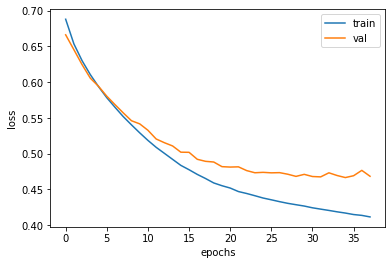

In [26]:
# Plot train loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()